# $E_{\text{peak}} - E_{\text{iso}}$ correlation

We have already performed a fit on the $E_\text{peak} - E_\text{iso}$ correlation, and, as mentioned in [Epeak_Eiso_correlation.ipynb](https://github.com/joanalnu/OAB-INAF/blob/main/Epeak_Eiso_correlation.ipynb) this relation between GRB properties can be used to constrain cosmological parameters. Namely, this is so because the isotropic equivalent energy $E_\text{iso}$ is derived from the flux $F$ by correcting for the distance and duration of the transient event.
$$E_\text{iso} = 4\pi D_L^2 S /(1+z)$$
Here, $S$ is the fluence (the time integrated flux $S = \lim_{\Delta t \to \infty} F\times t/(1+z) = \int^t Fdt$) and $D_L$ is the luminosity distance. This variable depends on a specific cosmology $\Omega$ and can be defined for a flat  Universe ($\Omega_k = 0$) as
$$D_L(z) = (1+z) \frac{c}{H_0} \int^z \frac{dz^\prime}{\sqrt{\Omega_{DE} + \Omega_m(1+z)^3}}$$
, neglecting the contribution of radiation $\Omega_R \sim 0.01$, $\implies \Omega = \Omega_{DE} + \Omega_m = 1$.

Given these equations, one can derive different $E_\text{iso}$ for different cosmologies, shifting the scatter points for the $E_\text{peak}-E_\text{iso}$ correlation. This correlation will have different values for the free parameters $(m,k)$, assuming ($\log E_\text{peak} = m\times \log E_\text{iso} + k$ depending on the cosmology. Thus, we can define a parameter grid with $(\Omega_{DE},\Omega_m)$ and computing the scatter of the fit with the data, i.e., creating a $\chi^2 (\Omega_{DE},\Omega_m)$ surface. Assuming that this is a physical correlation, the minimum of $\chi^2$ (indicating a less-scattered fit) will point the 'best cosmology.'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import goodness_of_fit

In [7]:
# read data
df = pd.read_csv('table.csv')

def kev_to_ergs(col):
    # 1 erg = 10**-3 * 6.242*10**11 keV
    return np.array([val*6.242*10**8 for val in col])

Epeak = np.log10(df['Epeak'])
Epeak_err = np.log10(df['Epeak_err'])
z = df['z']
S = df['Fluence'] # ergs/cm2
S_err = df['Fluence_err']

In [74]:
# constants and equations
# H0 = 70 # km/s/Mpc
H0 = 2.27 * (10**-18) # in cgs units
c = 29979245800 # cm/s

# predefined flat cosmology
Om = 0.3
Ode = 0.7

def luminosity_distance(redshift, Ho=H0, O_m=Om, O_DE=Ode):
    def luminosity_distance_single(z, Ho=H0, O_m=Om, O_DE=Ode):
        def integrand(z_prime, O_m=Om, O_DE=Ode):
            return 1/np.sqrt(O_m*(1+z_prime)**3 + O_DE)
        integral, _ = quad(integrand, 0, z, args=(O_m, O_DE))
        return (c * (1+z)/Ho) * integral
    return np.array([luminosity_distance_single(z_i, Ho, O_m, O_DE) for z_i in redshift])

def isotropic_equivalent_energy(redshift, fluence, H0=H0, Omega_m=Om, Omega_DE=Ode):
    numerator = 4.*np.pi* (luminosity_distance(redshift, H0, Omega_m, Omega_DE)**2) *fluence
    return np.log10(numerator/(1+z))

Above, we have read the data and defined key constants and functions, such as computing the luminosity distance and isotropic equivalent energy for a cosmology. Next, we'll try plotting $E_{\text{iso}, \bar{\Omega}}$ vs. $E_\text{iso}$ (from the table). Note that, until now, we have used a standard flat cosmology $h = \Omega_{DE} = 0.7$.

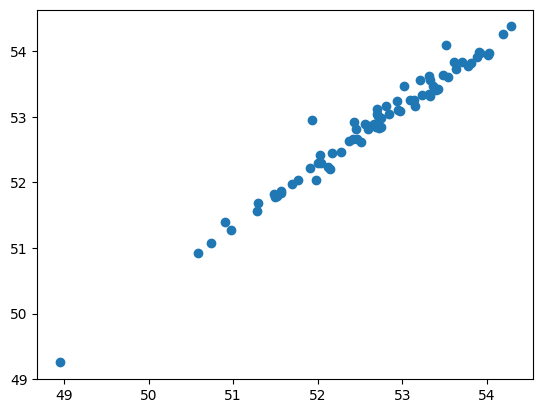

In [15]:
Eiso = isotropic_equivalent_energy(z, S, H0=H0, Omega_m=Om, Omega_DE=Ode)
plt.figure()
plt.scatter(Eiso, np.log10(df['Eiso']))

 Since the line of points is not exactly straight (has some noise), I want to define a simple model $E_{\text{iso}, \bar{\Omega}} = k \times E_\text{iso}$, to find the proportionality factor $k$. In addition, the standard deviation and $\chi^2$ value are also computed.

Chi^2 = 2.1920225781879954
Standard deviation = 0.23712227675452066


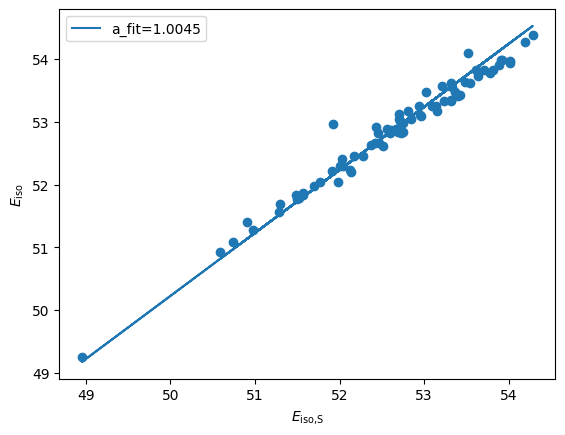

In [43]:
def GoF(k, x=Eiso, y=np.log10(df['Eiso'])):
    """
    Returns the sum of the squared errors for the fit.
    :param k: Factor
    :param x: x-values
    :param y: y-values
    :return: sum for least squares fit
    """
    model = x*k
    return np.sum((model-y)**2)

k = np.linspace(0.5,1.5,1000)
G = np.zeros(len(k))
for i in range(len(k)):
    G[i] = GoF(k[i])

k_fit = k[np.unravel_index(np.argmin(G), G.shape)]

plt.figure()
plt.scatter(Eiso, np.log10(df['Eiso']))
plt.plot(Eiso, k_fit*Eiso, label=f'k_fit={k_fit:.4f}')
plt.legend()
plt.xlabel(r'$E_\text{iso,S}$')
plt.ylabel(r'$E_\text{iso}$')

def std_dev(x, mu):
    r = np.sum((x-mu)**2)
    return np.sqrt(r/len(x))

print(f'Chi^2 = {GoF(k_fit)}')
print(f'Standard deviation = {std_dev(Eiso, k_fit*Eiso)}')

---
# Cosmological uses
In this next part of the notebook, we are going to use $E_{\text{iso}, \Omega}$ to constrain cosmological parameters. The approach for this is to create a parameter space for $(\Omega_{DE}, \Omega_m)$ and fit the $E_\text{peak} - E_\text{iso}^*$ correlation for each combination of parameters. For each fitted line, we will measure the distance from the data points to the fit using metric geometry. For 2D the distance between a line $l$ and a point $P = (x,y)$ is
$$d(P,l) = \frac{|\vec{P_0 P}\times \vec{v}|}{|\vec{v}|}$$
where

$$\begin{cases}
    \vec{P_0 P} = P - P_0 \quad;\text{ with } P_0 = (x, \text{fit}(x)) \\
    \vec{v} = \begin{pmatrix}1\\a\end{pmatrix}\quad;\text{the director vector of } y = ax+b\\
    |\vec{v}| = \sqrt{v_1^2 + v_2^2}
\end{cases}$$

$^*$ From now on, we will use $E_\text{iso}$ as the isotropic equivalent energy derived from a specific cosmology.

In [50]:
import numpy as np

def measure_distances(x, y, a, b):
    def measure_distance_single(p, a, b):
        """
        Measures the distance between a point p = (x,y) and a line of best fit y=ax+b.
        :param p: coordinates of the point
        :param a: slope of the fit
        :param b: y-axis cut of the fit
        :return: scalar for the distance
        """
        x_p, y_p = p
        # Perpendicular distance from point to line y = ax + b
        # Formula: |y_p - ax_p - b| / sqrt(1 + a^2)
        numerator = abs(y_p - a*x_p - b)
        denominator = np.sqrt(1 + a**2)
        return numerator/denominator

    distances = []
    for i in range(len(x)):
        distance = measure_distance_single((x[i], y[i]), a, b)
        distances.append(distance)

    return distances

def gof_without_errors(a, b, x, y):  # Remove default parameters
    """
    Goodness of fit following the chi-squared formula
    :param a: slope
    :param b: y-axis cut
    :param x: x-values
    :param y: y-values
    :return: chi-squared value
    """
    model = a*x + b
    return np.sum((y-model)**2)

In [75]:
Om = np.linspace(0.0,1.0,10) # define completely free parameters
Ode = np.linspace(0.0,1.0,10)
#Om = np.linspace(0.1,0.5,100) # define Om = 0.3±0.2
#Ode = np.linspace(0.5,0.9,100) # define Ode = 0.7±0.2
a = np.linspace(-25.,-20.,100) # from previous notebooks
b = np.linspace(0.0,1.0,100) # slope must be positive

# for now, we will continue with fixed h = 0.7

data = np.zeros([len(Om), len(Ode), len(Eiso)])

for i in range(len(Om)):
    for j in range(len(Ode)):
        G = np.zeros([len(a), len(b)])
        for k in range(len(a)):
            for l in range(len(b)):
                G[k,l] = gof_without_errors(a[k], b[l], isotropic_equivalent_energy(z, S, H0, Om[i], Ode[j]), Epeak)  # Fix indexing

        a_id, b_id = np.unravel_index(np.argmin(G), G.shape)
        a_fit, b_fit = a[a_id], b[b_id]

        # Get distances and compute some metric (e.g., mean distance)
        data[i,j,:] = measure_distances(Eiso, Epeak, a_fit, b_fit)

np.save('distances.npy', data)

/var/folders/lq/7_q5kjhn1pzgzvpl0fk8y5mc0000gp/T/ipykernel_26057/3386486911.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/np.sqrt(O_m*(1+z_prime)**3 + O_DE)


KeyboardInterrupt: 

At this point we have computed the distances between data points and fitted line for each combination of $(\Omega_m, \Omega_{DE})$ and stored the information in a 3-dimensional npy array (and file `distances.npy`). Next, we will use this array and compute the sum of the distances for each case. Then plot a $D(\Omega_m, \Omega_{DE})$ surface and find the minimum.

In [70]:
d = np.load('distances.npy', allow_pickle=True)

for i in range(len(Ode)):
    print(f'{i}\t')
print('\n')

for i in range(len(Om)):
    for j in range(len(Ode)):
        print(f'{[d[i,j,k] for k in range(75)]}')

    print('\n')

0	
1	
2	
3	
4	
5	
6	
7	
8	
9	


[np.float64(52.140087663479775), np.float64(51.50950904521567), np.float64(53.38344453400934), np.float64(53.34850606455276), np.float64(51.269995986756186), np.float64(51.49459985473573), np.float64(52.76744585361393), np.float64(54.33177630237442), np.float64(53.93977175554477), np.float64(53.11033947189217), np.float64(53.15456425031913), np.float64(51.47344901506134), np.float64(53.325485425469935), np.float64(53.73536760364217), np.float64(54.21526156097231), np.float64(53.1801399174872), np.float64(51.935634499903756), np.float64(53.854747284749635), np.float64(53.43244130424881), np.float64(53.91711654203389), np.float64(51.966497661720034), np.float64(52.44796375710983), np.float64(53.25296224741509), np.float64(52.99187515594894), np.float64(53.62536577554341), np.float64(51.54960101093208), np.float64(48.86749338018096), np.float64(52.52199792845534), np.float64(51.75136876040862), np.float64(52.733106222486164), np.float64(53.34313014643669), 

In [71]:

sum_d = np.zeros([len(Om), len(Ode)])
for i in range(len(Om)):
    for j in range(len(Ode)):
        sum_d[i,j] = np.sum(d[i,j,:])

print(sum_d)

[[3948.11281719 3948.11281719 3948.11281719 3948.11281719 3948.11281719
  3948.11281719 3948.11281719 3948.11281719 3948.11281719 3948.11281719]
 [3948.11281719 3948.11281719 3948.11281719 3948.11281719 3948.11281719
  3948.11281719 3948.11281719 3948.11281719 3948.11281719 3948.11281719]
 [3948.11281719 3948.11281719 3948.11281719 3948.11281719 3948.11281719
  3948.11281719 3948.11281719 3948.11281719 3948.11281719 3948.11281719]
 [3948.11281719 3948.11281719 3948.11281719 3948.11281719 3948.11281719
  3948.11281719 3948.11281719 3948.11281719 3948.11281719 3948.11281719]
 [3948.11281719 3948.11281719 3948.11281719 3948.11281719 3948.11281719
  3948.11281719 3948.11281719 3948.11281719 3948.11281719 3948.11281719]
 [3948.11281719 3948.11281719 3948.11281719 3948.11281719 3948.11281719
  3948.11281719 3948.11281719 3948.11281719 3948.11281719 3948.11281719]
 [3948.11281719 3948.11281719 3948.11281719 3948.11281719 3948.11281719
  3948.11281719 3948.11281719 3948.11281719 3948.11281719 

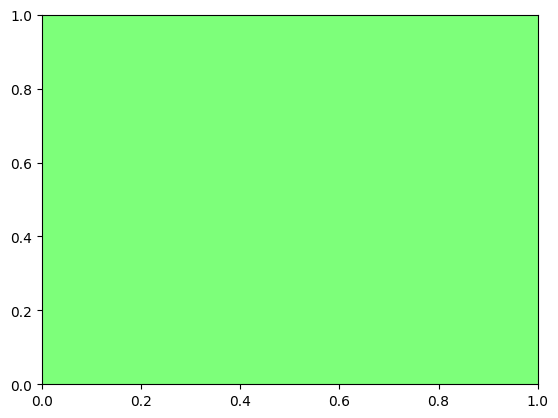

In [72]:
plt.figure()
plt.contourf(Om, Ode, np.log10(sum_d), cmap='jet')
#plt.colorbar(r'$\log_10 {\text{sum_d}}$')